# Abstract

In this Blog Post, we will examine racial disparities in healthcare algorithms. We will look at medical expenditures and patient risk scores to try and reproduce what Obermeyer et al. found in their 2019 study. We will use a polynomial Ridge regression to find the cost Black patients incur when compared to White Patients. We will find that on average, Black patients incur 77% of the medical costs of equally sick White patients which aligns with what Obermeyer et al. found. These findings suggest that cost-based risk algorithms may systematically underestimate the healthcare needs of Black patients.

In [79]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

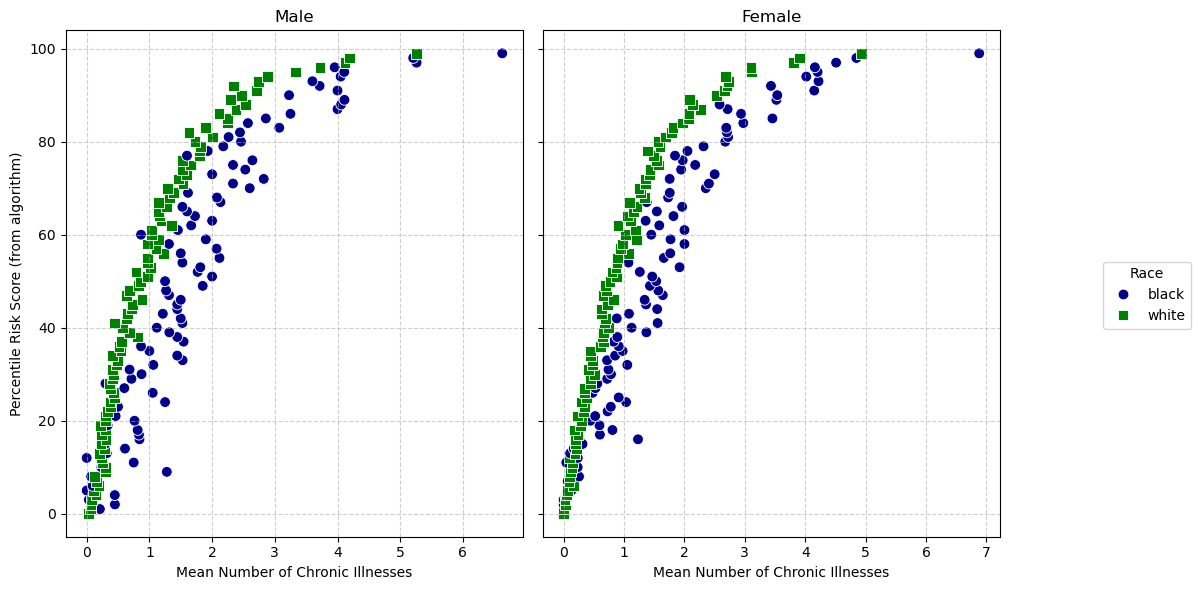

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Go through the columns and save the sames of the columns that end in '_elixhauser_tm1' 
chronic_condition_cols = [col for col in df.columns if col.endswith('_elixhauser_tm1')]

# Add column for the percentile using qcut
df['risk_score_percentile'] = pd.qcut(df['risk_score_t'], 100, labels=False)

# Number of chronic conditions for each patient
df['num_active_chronic_conditions'] = df[chronic_condition_cols].sum(axis=1)

# Mean number of active chronic conditions WITHIN each risk score percentile
summary_df = df.groupby(['risk_score_percentile', 'dem_female', 'race'])[
    'num_active_chronic_conditions'].mean().reset_index()


fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Define color palette and marker styles for race:
palette = {"black": "darkblue", "white": "green"}
fixed_markers = {"black": "o", "white": "s"} 

# Loop through genders
for i, (gender_label, gender_value) in enumerate([("Male", 0), ("Female", 1)]):
    ax = axes[i]
    subset = summary_df[summary_df["dem_female"] == gender_value]

    # Scatter plot:
    sns.scatterplot(
        data=subset,
        x="num_active_chronic_conditions",  # Now using the correctly calculated mean
        y="risk_score_percentile",
        hue="race",
        style="race",
        palette=palette,
        markers=fixed_markers,
        s=60,
        ax=ax
    )

    ax.set_xlabel("Mean Number of Chronic Illnesses")
    ax.set_title(gender_label)
    ax.grid(True, linestyle="--", alpha=0.6)

# Set y-label on the left plot only
axes[0].set_ylabel("Percentile Risk Score (from algorithm)")

# Place a common legend on the right side of the figure
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Race", loc="center right")

# Remove individual legends from each subplot
axes[0].get_legend().remove()
axes[1].get_legend().remove()

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend
plt.show()


The graph shows that for the same number of chronic illnesses, Black patients (blue circles) tend to receive lower risk scores compared to White patients. Since risk scores are often used to determine eligibility for high-risk care management programs, this suggests that Patient A (Black) is less likely to be referred than Patient B (White), despite having the same health conditions. This gap implies that the algorithm may be underestimating the healthcare needs of Black patients, potentially due to its reliance on healthcare spending patterns rather than direct clinical measures. There looks like there is bias baked in here. As a result, Black patients may face reduced access to critical medical interventions, highlighting a racial bias in the risk assessment process that could contribute to inequities in healthcare treatment and outcomes.

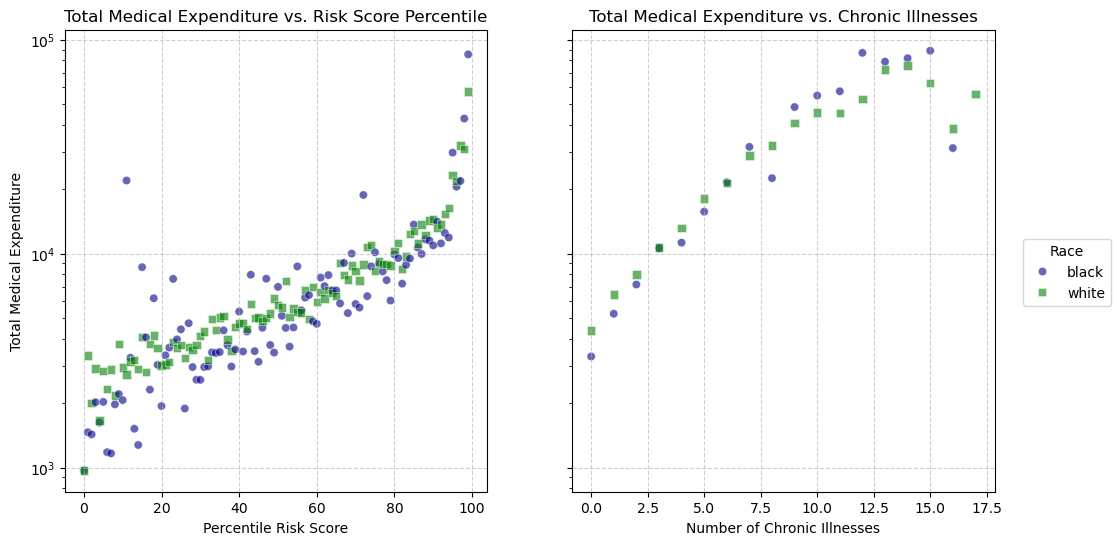

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mean total medical expenditure per percentile of risk score
risk_score_summary = df.groupby(['risk_score_percentile', 'race'])['cost_t'].mean().reset_index()

# Mean total medical expenditure per number of chronic conditions
chronic_condition_summary = df.groupby(['gagne_sum_t', 'race'])['cost_t'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)


# Expenditure vs. Risk Score Percentile
sns.scatterplot(
    data=risk_score_summary,
    x="risk_score_percentile",
    y="cost_t",
    hue="race",
    style="race",
    palette=palette,
    markers = fixed_markers,
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_xlabel("Percentile Risk Score")
axes[0].set_ylabel("Total Medical Expenditure")
axes[0].set_yscale("log")
axes[0].set_title("Total Medical Expenditure vs. Risk Score Percentile")
axes[0].grid(True, linestyle="--", alpha=0.6)

# Expenditure vs. Number of Chronic Illnesses
sns.scatterplot(
    data=chronic_condition_summary,
    x="gagne_sum_t",
    y="cost_t",
    hue="race",
    style="race",
    palette=palette,
    markers = fixed_markers,
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_xlabel("Number of Chronic Illnesses")
axes[1].set_title("Total Medical Expenditure vs. Chronic Illnesses")
axes[1].set_yscale("log") 
axes[1].grid(True, linestyle="--", alpha=0.6)

# Adjust legend position
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Race", loc="center right")

# Remove individual legends from subplots
axes[0].get_legend().remove()
axes[1].get_legend().remove()


plt.show()


The graph reveals relationship between total medical expenditure and both risk score percentile and number of chronic illnesses. Again, it is obvious here that there is a disparity between black vs white. In the left panel, we see that as risk score percentiles increase, total medical expenditure rises. This makes sense, but when you take a look at black paitents, you see that Black patients consistently have lower expenditures than White patients at the same risk score percentile except for a few outliers. Similarly as the earleir plot, this suggests that the algorithm may underestimate the healthcare needs of Black patients or that they receive fewer medical interventions despite similar risk assessments.

In the right panel, a similar trend emerges: as the number of chronic illnesses increases, total medical expenditures also increase, but again, Black patients tend to have lower expenditures than White patients with the same number of chronic conditions. The exact cause of this difference could be caused by a few things like differences in healthcare access, treatment patterns, or systemic biases in how medical resources are dispersed.

In [ ]:
subset_df = df[df["gagne_sum_t"] <= 5]
(len(subset_df) / len(df)) * 100

95.53952115447689

Our decision to focus on patients with 5 or fewer chronic conditions is supported by the fact that they make up approximately 96% of the dataset. This ensures that our analysis remains representative of the majority of patients while minimizing the influence of extreme cases with very high chronic condition counts. Additionally, as the number of chronic conditions increases, the number of patients in those categories becomes much smaller, leading to increased variability in medical costs and potential instability in the model.

In [83]:
# Remove patients with $0 medical cost (log(0) is undefined)
df = df[df["cost_t"] > 0]

# Apply natural log transformation to medical cost
df["log_cost_t"] = np.log(df["cost_t"])

df[["cost_t", "log_cost_t"]].head()

,cost_t,log_cost_t
0,1200.0,7.090077
1,2600.0,7.863267
2,500.0,6.214608
3,1300.0,7.170120
4,1100.0,7.003065


In [84]:
# Create a dummy variable for race
df["race_black"] = (df["race"] == "black").astype(int)


In [87]:
# Define predictor variables (X) and target variable (y)
X = df[["race_black", "gagne_sum_t"]]  # Predictors: race and number of chronic illnesses
y = df["log_cost_t"]  # Target: log-transformed medical cost

In [88]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import warnings

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Step 2: Function to generate polynomial features efficiently
def add_polynomial_features(X, degree):
    X_ = X.copy()
    for j in range(1, degree):  # Start at degree 2 for additional features
        X_[f"poly_{j}"] = (X_["gagne_sum_t"] ** j).astype("float32")  # Ensure memory-efficient float32
    return X_

# Step 3: Loop through polynomial degrees (1 to 11) and regularization strengths (10^k for k = -4 to 4)
degrees = range(1, 12)
alphas = [10 ** k for k in range(-4, 5)]

best_score = float("inf")
best_params = None

# Suppress warnings during model fitting
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Grid search over polynomial degrees and regularization strengths with memory optimization
    for degree in degrees:
        X_poly = add_polynomial_features(X, degree)  # Add polynomial features

        for alpha in alphas:
            model = Ridge(alpha=alpha)  # Ridge regression with given alpha
            scores = cross_val_score(model, X_poly, y, scoring="neg_mean_squared_error", cv=5) 
            mean_score = -np.mean(scores)  # Convert to positive MSE

            if mean_score < best_score:  # Track best combination
                best_score = mean_score
                best_params = (degree, alpha)

# Display best parameters found
print(f"Best Polynomial Degree: {best_params[0]}")
print(f"Best Regularization Strength (alpha): {best_params[1]}")
print(f"Best Cross-Validated MSE: {best_score:.4f}")


Best Polynomial Degree: 10
Best Regularization Strength (alpha): 1
Best Cross-Validated MSE: 1.5084


In [89]:
best_degree = best_params[0]
best_alpha = best_params[1]

X_poly = add_polynomial_features(X, best_degree)
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_poly, y)

Ridge(alpha=1)

In [90]:
X_poly.head()

,race_black,gagne_sum_t,poly_1,poly_2,poly_3,poly_4,poly_5,poly_6,poly_7,poly_8,poly_9
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,3,3.0,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0,19683.0
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Because race_black is the first column in our training data, we need the first coefficent because it corresponds to race_black.

In [91]:
race_black_coef = final_model.coef_[0]
race_black_coef

np.float64(-0.26704537754160196)

In [92]:
cost_ratio = np.exp(race_black_coef) * 100
cost_ratio

np.float64(76.56383278920148)

I found a cost ratio of 77%. This suggests that on average, Black patients incur only 77% of the medical expenditures of White patients with the same number of chronic illnesses. I would say that this aligns with the results of Obermeyer et al., which identified that Black patients were assigned lower risk scores than White patients with the same level of medical complexity, leading to under-allocation of healthcare resources. This means that in industry, cost-based algorithms are used to determine patient risk, and they may systematically underestimate the healthcare needs of Black patients. This supports Obermeyer et al.'s argument that cost is an inadequate proxy for healthcare need and that such models must be adjusted to account for racial biases.

# Discussion

I conclude that what I replicated from Obermeyer et al demonstrates a racial bias that doesn't satisfy the sufficiency criterion. Obermeyer et al. found that Black patients had more chronic illnesses than White patients at the same risk score, meaning that the model’s predictions were not equally valid across racial groups. This is a violation of sufficiency because the same predicted risk score does not correspond to the same true healthcare need across Black and White patients. As a result, Black patients are systematically assigned lower risk scores despite having a higher actual burden of illness. This leads to a reduced access to critical healthcare resources, where they only get about 77% of the spending as White patients. This study highlights the dangers of relying on cost-based algorithms for risk assessment.